# Optimizing T Counts Given an Error Budget

Quantum algorithms typically only allow us to estimate properties to within some additive error $\epsilon$. For quantum phase estimation via Trotterization there are at least three sources of error [[1]](https://arxiv.org/abs/1902.10673): Trotter errors ($\Delta_{TS}$), circuit synthesis errors ($\Delta_{HT}$), and phase estimation errors ($\Delta_{PE}$).

###  1. Trotter Errors

Given a $p$-th order product formula $S_p(t)$ for the unitary implementing $e^{-i t H}$ we have that 
$$
\Delta_U \equiv \lVert S_p(t) - e^{-i t H}\rVert_{W_\eta} = \xi(\eta, u, \tau) t^{p+1}
$$
for some constant $\xi$ which depends on the parameters of the system. The constant $\xi$ can be either computed (through direct evaluation and extrapolating from small system sizes) or bounded using complicated commutator expressions.

Ref. [[1]](https://arxiv.org/abs/1902.10673) showed that

$$
\Delta_{TS} t \equiv |E - E_{TS}|t \le \arctan\left(\Delta_U \frac{\sqrt{4-\Delta_U^2}}{2-\Delta_U^2}\right) = \Delta_U + \frac{\Delta_U^3}{24} + \mathcal{O}(\Delta_U^5),
$$
so that as long as $\Delta_U \gg \frac{\Delta_U^3}{24}$ we can estimate 

$$
\Delta_{TS} = \Delta_U / t \approx \xi(\eta, u, \tau) t^{p} 
$$

### 2. Circuit Synthesis Errors

Circuit synthesis errors account for the approximate implementation of single qubit $R_z(\theta)$ rotations when compiled to  Clifford+$T$ gates. A single qubit rotation gate can be synthesized to $\epsilon_R$ error using
$$
T_\mathrm{synth} \approx 1.15 \log_2(1/\epsilon_R) + 9.2
$$
$T$ gates. Assuming these errors add at most linearly to the estimated phase then the cost is

$$
N_{HT} = 1.15 \log_2 \left(\frac{N_R}{\Delta_{HT} t}\right) + 9.2
$$
$T$ gates per single qubit rotation, where $N_R$ is the number of rotations per Trotter step.

### 3. QPE Errors

Phase estimation errors $\Delta_{PE}$ arise due to not computing enough bits of the phase. Adaptive phase estimation allows one to reach a RMS error of $\Delta_{PE} t$ using

$$
N_{PE} \approx \frac{0.76 \pi}{\Delta_{PE} t}
$$
repetitions of the simulation circuit.

## Optimizing the T counts

We assume $\epsilon \ge \Delta_{PE} + \Delta_{TS} + \Delta_{HT}$. There is some freedom for the relative weighting of these terms and we can minimize the $T$ count which this constraint. The total $T$ count comes from the Trotter step costs and the number of QPE repetitions $N_{PE}$

$$
N_{\mathrm{tot}} = N_{PE} (N_{R} N_{HT} + N_T)
$$
where $N_T$ is the number of "direct" $T$ gates (i.e. those that appear in the circuit before synthesis).

If we write $t = \left(\frac{\Delta_{TS}}{\xi}\right)^{1/p}$, then
$$
N_\mathrm{tot} \approx \frac{0.76 \pi \xi^{1/p}}{\Delta_{PE}\Delta_{TS}^{1/p}}\left(N_R \left[\log\left(\frac{N_R \xi^{1/p}}{\Delta_{HT}\Delta_{TS}^{1/p}}\right) + 9.2\right] + N_T\right)
$$

Ref. [[1]](https://arxiv.org/abs/1902.10673) minimized this expression numerically. Qualtran should be able to produce this expression and perform the optimization. 

### Numerical Minimization

Let us first reproduce the results from [[2]](https://arxiv.org/abs/2012.09238) for the PLAQ Hubbard splitting through direct minimization. We will then see how Qualtran can help with this analysis.

In [1]:
from typing import Dict, Union, Tuple

import numpy as np
import sympy

from qualtran.cirq_interop.t_complexity_protocol import TComplexity
from qualtran.resource_counting.symbolic_counting_utils import ceil
from qualtran.resource_counting.t_counts_from_sigma import _get_all_rotation_types
from qualtran.resource_counting.generalizers import PHI
from qualtran import Bloq
from qualtran.bloqs.basic_gates import TGate, Rz
from qualtran.bloqs.util_bloqs import ArbitraryClifford

def catch_rotations(bloq) -> Bloq:
    """Generalizer to catch rotations."""
    if isinstance(bloq, Rz):
        if abs(bloq.angle) < 1e-12:
            return ArbitraryClifford(1)
        else:
            return Rz(angle=PHI, eps=bloq.eps)
    return bloq

def t_and_rot_counts_from_sigma(
    sigma: Dict['Bloq', Union[int, 'sympy.Expr']],
) -> Tuple[int, int]:
    rotation_types = _get_all_rotation_types()
    ret = sigma.get(TGate(), 0)
    n_rot = 0
    for bloq, counts in sigma.items():
        if isinstance(bloq, rotation_types):
            n_rot += counts
    return ret, n_rot

def timestep_from_params(delta_ts: float, xi: float, prod_ord: int) -> float:
    """Get the timestep from the product formula spectral norm error.

    Args
        delta_ts: The allowed Suzuki-Trotter error.
        xi: The constant factor for the Trotter-Suzuki spectral norm error.
        prod_ord: The product formula order.
    Returns:
        timestep: The computed timestep.
    """
    return (delta_ts / xi) ** (1.0 / prod_ord)


def get_single_rot_eps(n_rot: int, delta_ht: float, timestep: float) -> int:
    """Get the precision required for single qubit rotations given n_rot of them.

    Args:
        delta_ht: The allowed circuit synthesis error.
        n_rot: The number of rotations in the circuit.
        timestep: The timestep for trotterization. 

    Returns:
        eps: the precision for single qubit rotations
    """
    return (delta_ht * timestep) / n_rot


def qpe_steps(delta_pe: float, timestep: float) -> int:
    """Get the number of QPE steps from the RMS error and timestep.

    Args:
        delta_pe: The desired adaptive phase estimation RMS error.
        timestep: The timestep value.

    Returns:
        n_qpe: The number of QPE steps.
    """
    return (0.76 * np.pi) / (delta_pe * timestep)

def rotation_cost(n_rot: int, delta_ht: float, timestep: float) -> int:
    """Get the rotation costs.

    Args:
        delta_ht: The allowed circuit synthesis error.
        n_rot: The number of rotations in the circuit.
        timestep: The timestep value.
    """
    # rot_cost = TComplexity(rotations=n_rot).t_incl_rotations(
    #     get_single_rot_eps(n_rot, delta_ht, timestep)
    # )
    return n_rot * (1.149 * np.log2(n_rot / (delta_ht * timestep)) + 9.2)
    return rot_cost


def qpe_t_count(
    delta_pe: float,
    delta_ts: float,
    delta_ht: float,
    n_rot: int,
    n_t: int,
    xi: float,
    prod_ord: int,
) -> int:
    """Compute the total number of T gates used for Trotterized QPE.

    Args:
        delta_pe: The allowed phase estimation error.
        delta_ts: The allowed Suzuki-Trotter error.
        delta_ht: The allowed circuit synthesis error.
        n_rot: The number of rotations in the circuit.
        n_t: The number of direct T gates (before synthesis).
        xi: The constant factor for the Trotter-Suzuki spectral norm error.
        prod_ord: The product formula order.

    Returns:
        tot_t_cost: The total number of T gates.
    """
    timestep = timestep_from_params(delta_ts, xi, prod_ord)
    rot_cost = rotation_cost(n_rot, delta_ht, timestep)
    n_qpe = qpe_steps(delta_pe, timestep)
    tot_t_cost = n_qpe * (rot_cost + n_t)
    return tot_t_cost

/usr/local/google/home/fmalone/.venvs/qualtran/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
# Get some system parameters from Ref. [2]
# 8x8 lattice
length = 8
hubb_u = 4

# From Ref[2] table 1.
xi_bound = 5.3e2 
# Fig 2. from Ref[2] uses this extensive size error (we're targeting some energy per lattice site)
epsilon = 0.0051 * length**2
# Arbitrary splitting of error for comparison purposes
delta_ts = 0.5 * epsilon 
delta_pe = 0.45 * epsilon 
delta_ht = 0.05 * epsilon 
# using 2nd order Suzuki (Strang) splitting
prod_ord = 2
timestep = timestep_from_params(delta_ts, xi_bound, prod_ord)
print(f"Computed timestep: {timestep:4.3e}")
print(f"Sum Error budget terms: {delta_ts + delta_ht + delta_pe}")
print(f"Expected Error budget: {epsilon}")

Computed timestep: 1.755e-02
Sum Error budget terms: 0.3264
Expected Error budget: 0.3264


Let's first check the fixed costs from the Trotter step match our expectations 

In [3]:
from qualtran.bloqs.chemistry.trotter.hubbard.trotter_step import build_plaq_unitary_second_order_suzuki

trotter_step = build_plaq_unitary_second_order_suzuki(length, hubb_u, timestep, eps=1e-10)
n_t, n_rot = t_and_rot_counts_from_sigma(trotter_step.call_graph(generalizer=catch_rotations)[1])
print(f"N_T = {n_t} vs {(3*length**2 // 2)*8}")
print(f"N_rot = {n_rot} vs {(3 * length**2 + 2*length**2)}")

N_T = 768 vs 768
N_rot = 320 vs 320


Now let's look at the total cost and the error we incurred with our default parameter choices.

Adjusted eps_single_rot: 8.949367006180983e-07


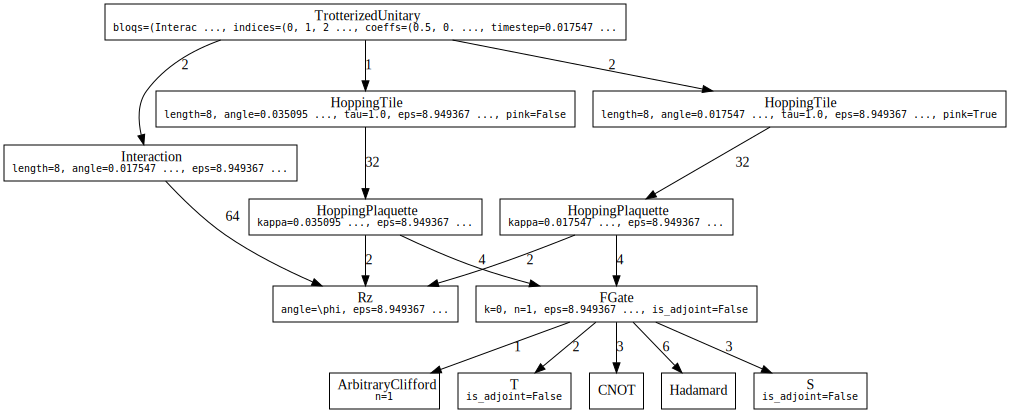

In [4]:
import attrs
from qualtran.drawing import show_call_graph
# get appropriate epsilon given our input parameters now we know the number of rotations
eps_single_rot = get_single_rot_eps(n_rot, delta_ht, timestep)
print(f"Adjusted eps_single_rot: {eps_single_rot}")
tot_t_count = qpe_t_count(delta_pe, delta_ts, delta_ht, n_rot, n_t, xi_bound, prod_ord)
# This doesn't really matter right now because the cost is determined directly
# from the formula assuming we used an appropriate delta_ht.
# But let's show the call graph anyway to check the parameters all all what we expect.
updated_eps_bloqs = tuple(attrs.evolve(b, eps=eps_single_rot) for b in trotter_step.bloqs)
trotter_step = attrs.evolve(trotter_step, bloqs=updated_eps_bloqs)
trotter_step_g, _ = trotter_step.call_graph(generalizer=catch_rotations)
show_call_graph(trotter_step_g)

In [5]:
tot_t_count = qpe_t_count(delta_pe, delta_ts, delta_ht, n_rot, n_t, xi_bound, prod_ord)
print(f"N_{{T_tot}} = {tot_t_count:4.3e} T gates.")

N_{T_tot} = 1.028e+07 T gates.


# Visualization

It's helpful at this point to do some visualization of the error dependencies.

Text(0, 0.5, 'Rotation Costs (Ts)')

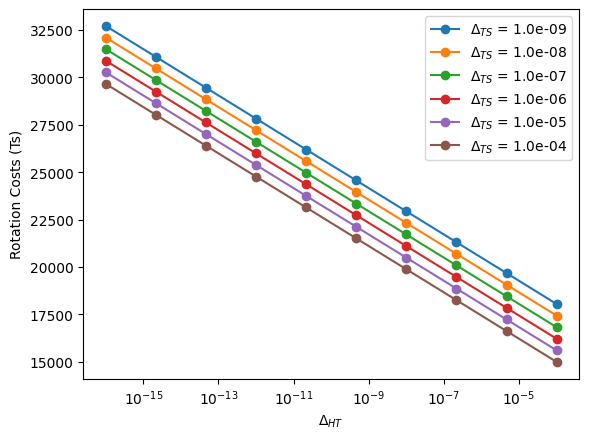

In [6]:
import matplotlib.pyplot as plt

delta_ts = np.logspace(-9, -4, 6)
delta_ht = np.logspace(-16, -4, 10)
for idt, dts in enumerate(delta_ts):
    synthesis_costs = [
        rotation_cost(n_rot, dht, timestep_from_params(dts, xi_bound, prod_ord)) for dht in delta_ht
    ]
    plt.plot(delta_ht, synthesis_costs, marker='o', color=fr'C{idt}', label=f'$\Delta_{{TS}}$ = {dts:2.1e}')
plt.legend()
plt.xscale('log')
plt.xlabel(r"$\Delta_{HT}$")
plt.ylabel(r"Rotation Costs (Ts)")

The $T$ count depends quite weakly on $\Delta_{HT}$ so we can take this to be relatively small and look at the dependence of the $T$ counts on just $\Delta_{TS}$ and $\Delta_{PE}$.

In [7]:
from matplotlib import cm

X = np.logspace(-2, -0.5, 20)
Y = np.logspace(-2, -0.5, 20)
X, Y = np.meshgrid(X, Y)
results = []
delta_ht = 1e-5
for x, y in zip(X, Y):
    for xval, yval in zip(x, y):
        results.append(np.log10(qpe_t_count(xval, yval, delta_ht, n_rot, n_t, xi_bound, prod_ord)))

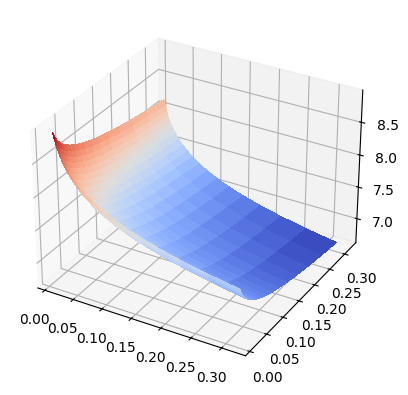

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, np.array(results).reshape(20, 20), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

Text(0.5, 1.0, 'Desired $\\epsilon$ = 0.0051 $L^2$ = 0.3264')

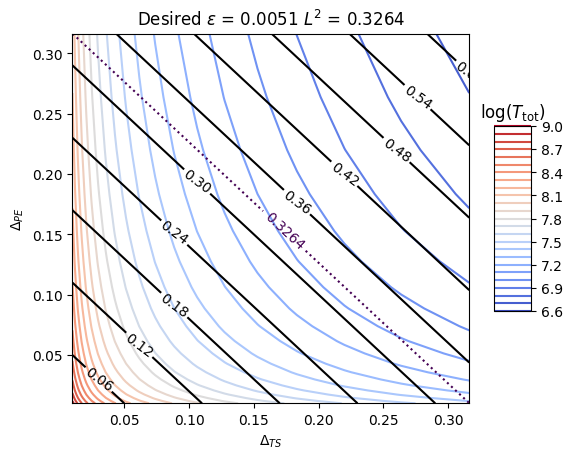

In [9]:
fig, ax = plt.subplots()
surf = ax.contour(
    X, Y, np.array(results).reshape(20, 20), 25, cmap=cm.coolwarm, 
)
cs = ax.contour(X, Y, X + Y, 10, colors="k", linestyles="solid")
ax.clabel(cs, inline=True, fontsize=10)
clb = fig.colorbar(surf, shrink=0.5, aspect=5)
clb.ax.set_title(r'$\log(T_\mathrm{tot}$)')
cs = ax.contour(X, Y, X+Y, levels=[epsilon], linestyles='dotted')
ax.clabel(cs, inline=True, fontsize=10)
ax.set_xlabel(r'$\Delta_{TS}$')
ax.set_ylabel(r'$\Delta_{PE}$')
ax.set_title(f'Desired $\epsilon$ = 0.0051 $L^2$ = {epsilon}')

In [10]:
print(f"{qpe_t_count(0.1, 0.25, delta_ht, n_rot, n_t, xi_bound, prod_ord):13.8e}")

1.63914029e+07


## Numerical Optimization

We can use scipy to optimize our $T$ counts subject to the constraint that $\Delta_{HT} + \Delta_{PE} + \Delta_{TS} \le \epsilon$.

In [14]:
from scipy.optimize import minimize
from numpy.typing import NDArray
import cvxpy


def objective(x: NDArray, n_rot: int, n_t: int, xi_bound: float, prod_ord: int) -> int:
    return qpe_t_count(x[0], x[1], x[2], n_rot, n_t, xi_bound, prod_ord)

def constraint 


# our constraints are
# a + b + c <= epsilon
constraint = (
    # {"type": "ineq", "fun": lambda x: -x[0] - x[1] -x[2] + epsilon},
    {"type": "ineq", "fun": lambda x: -x[0] -x[1] -x[2] + epsilon},
    # {"type": "ineq", "fun": lambda x: x[0] - 1e-8},
    # {"type": "ineq", "fun": lambda x: x[1] - 1e-8},
    # {"type": "ineq", "fun": lambda x: x[2] - 1e-8},
)
init_guess = [0.6, 0.6, delta_ht]
print(constraint[0]['fun'](init_guess) >= 0)
# print(constraint[1]['fun'](init_guess) >= 0)
# print(constraint[2]['fun'](init_guess) >= 0)
# print(constraint[3]['fun'](init_guess) >= 0)
print(init_guess)
args = (n_rot, n_t, xi_bound, prod_ord)
print(sum(init_guess))
# res = minimize(objective, x0=init_guess, bounds=[(1e-6, None) for i in range (3)], constraints=constraint, args=args, options={'disp': True})
res = minimize(objective_penalty, x0=init_guess, method='BFGS', args=args, options={'disp': True})
print(res.x, epsilon, objective(res.x, *args))
print(constraint[0]['fun'](res.x), sum(res.x) < epsilon)

False
[0.6, 0.6, 1e-05]
1.20001


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''